# INT303 Coursework1
Ruoyu Xu   
2142804

### Task 1 Scraping data


In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv
import time
import random
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Get the first 200 movie url for later scraping

In [3]:
# To deal with the "Load more" buttom
def get_page_soups(num_pages):
    base_url = 'https://www.themoviedb.org/movie'

    for i in range(1, num_pages + 1):
        url = f'{base_url}?page={i}'
        
        try:
            result = requests.get(url)
            result.encoding = 'utf-8'
            result.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)
        
            soup = BeautifulSoup(result.text, 'html.parser')
            yield soup      
            
        except requests.exceptions.RequestException as e:
            print(f"Error accessing {url}: {e}")
            continue

# Get 200 movie URL
def get_movie_urls(num_movies=200):
    movie_urls = []
    num_pages = (num_movies // 20) + 1 

    for soup in get_page_soups(num_pages):
        # Find all movie links in the page
        movie_links = [x['href'] for x in soup.find_all("a", class_="image") if '/movie/' in x['href']]
        
        for link in movie_links:
            full_url = f"https://www.themoviedb.org{link}"
            if full_url not in movie_urls: 
                movie_urls.append(full_url)
                
            if len(movie_urls) >= num_movies: 
                break
        
        if len(movie_urls) >= num_movies:
            break

    return movie_urls


movie_urls = get_movie_urls()

print(f"Collected {len(movie_urls)} movie URLs:")
for url in movie_urls:
    print(url)


Collected 200 movie URLs:
https://www.themoviedb.org/movie/1184918-the-wild-robot
https://www.themoviedb.org/movie/945961-alien-romulus
https://www.themoviedb.org/movie/933260-the-substance
https://www.themoviedb.org/movie/533535-deadpool-wolverine
https://www.themoviedb.org/movie/1029235-azrael
https://www.themoviedb.org/movie/917496-beetlejuice-beetlejuice
https://www.themoviedb.org/movie/1125510-el-hoyo-2
https://www.themoviedb.org/movie/519182-despicable-me-4
https://www.themoviedb.org/movie/1022789-inside-out-2
https://www.themoviedb.org/movie/1034541-terrifier-3
https://www.themoviedb.org/movie/1087822-hellboy-the-crooked-man
https://www.themoviedb.org/movie/814889-never-let-go
https://www.themoviedb.org/movie/726139
https://www.themoviedb.org/movie/1144962-transmorphers-mech-beasts
https://www.themoviedb.org/movie/1100782-smile-2
https://www.themoviedb.org/movie/912649-venom-the-last-dance
https://www.themoviedb.org/movie/889737-joker-folie-a-deux
https://www.themoviedb.org/movi

Define the method to scrap movie data in the task sheet

In [35]:
def get_movie_data(movie_url):
    
        response = requests.get(movie_url, verify=False)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')

        # Title
        title_tag = soup.find('h2')
        title = title_tag.find('a').text.strip() if title_tag else 'N/A'

        # Year
        release_year_tag = soup.find('span', class_='tag release_date')
        release_year = release_year_tag.text.strip('()') if release_year_tag else 'N/A'


        # User score
        score_tag = soup.find('div', class_='user_score_chart')
        score = score_tag['data-percent'] if score_tag and 'data-percent' in score_tag.attrs else 'N/A'

        # Description
        description_tag = soup.find('div', class_='overview')
        description = description_tag.find('p').text.strip() if description_tag and description_tag.find('p') else 'N/A'

        # Director
        def get_director_name(soup):
            profiles = soup.find_all('li', class_='profile')
            for profile in profiles:
                character_tag = profile.find('p', class_='character')
                if character_tag and 'Director' in character_tag.text:
                    name_tag = profile.find('a')
                    return name_tag.text.strip() if name_tag else 'N/A'
            return 'N/A'

        director = get_director_name(soup)

        # Screenplayer
        def get_screen_name(soup):
            profiles = soup.find_all('li', class_='profile')
            for profile in profiles:
                character_tag = profile.find('p', class_='character')
                if character_tag and 'Screenplay' in character_tag.text:
                    name_tag = profile.find('a')
                    return name_tag.text.strip() if name_tag else 'N/A'
            return 'N/A'

        screen_player = get_screen_name(soup)

        # Type
        type_tag = soup.find('span', class_='genres')
        type = ', '.join([a.text.strip() for a in type_tag.find_all('a')]) if type_tag else 'N/A'


        # Revenue
        revenue = 'N/A'
        facts_section = soup.find('section', class_='facts')
        if facts_section:
            fact_items = facts_section.find_all('p')
            for fact in fact_items:
                label_tag = fact.find('strong')
                if label_tag:
                    label_text = label_tag.get_text(strip=True)
                    value_text = fact.get_text(strip=True).replace(label_text, '').strip()
                    if label_text in ['Revenue', '票房']:
                        revenue = value_text

        return {
            'Title': title,
            'Year': release_year,
            'User Score': score,
            'Description': description,
            'Director': director,
            'Screenplay': screen_player,
            'Type': type,
            'Revenue': revenue
        }


# # Test
# if __name__ == "__main__":
#     movie_url = "https://www.themoviedb.org/movie/1184918-the-wild-robot"
#     movie_data = get_movie_data(movie_url)
#     
#     if movie_data:
#         print("Movie Data:")
#         for key, value in movie_data.items():
#             print(f"{key}: {value}")
#     else:
#         print("Failed to retrieve movie data.")


In [4]:
# Define the method to scrap movie data in the task sheet
def scrape_movies(movie_urls):
    # 初始化 DataFrame
    movies_df = pd.DataFrame()
    
    # 使用 tqdm 包装 movie_urls 以实现进度条
    for movie_url in tqdm(movie_urls, desc="Scraping Movies", unit="movie"):
        time.sleep(0.5 * random.random())
        
        # 获取单个电影详情
        movie_detail = get_movie_data(movie_url)
        
        if movie_detail:
            # 将当前电影数据转换为 DataFrame 并拼接到主 DataFrame
            movies_df = pd.concat([movies_df, pd.DataFrame([movie_detail])], 
                                   ignore_index=True)
            
    return movies_df

In [18]:
movie_df = scrape_movies(movie_urls)
movie_df.to_csv('/Users/xuruoyu/Desktop/movies.csv')
print("Movie data file saved")
movie_df

Scraping Movies: 100%|██████████| 200/200 [07:59<00:00,  2.40s/movie]

Movie data file saved


,Title,Year,User Score,Description,Director,Screenplay,Type,Revenue
0,The Wild Robot,2024,87,"After a shipwreck, an intelligent robot called...",Chris Sanders,Chris Sanders,"Animation, Science Fiction, Family","$196,822,000.00"
1,Alien: Romulus,2024,73,While scavenging the deep ends of a derelict s...,Fede Álvarez,N/A,"Science Fiction, Horror","$348,521,150.00"
2,The Substance,2024,73,A fading celebrity decides to use a black mark...,Coralie Fargeat,N/A,"Horror, Drama, Science Fiction","$29,106,531.00"
3,Deadpool & Wolverine,2024,77,A listless Wade Wilson toils away in civilian ...,Shawn Levy,N/A,"Action, Comedy, Science Fiction","$1,334,640,330.00"
4,Azrael,2024,61,"In a world where no one speaks, a devout femal...",E.L. Katz,N/A,"Action, Horror, Thriller",-
...,...,...,...,...,...,...,...,...
195,Duchess,2024,63,"A tough, working-class petty criminal is drawn...",Neil Marshall,N/A,"Action, Crime, Thriller",-
196,Alienoid,2022,68,Gurus in the late Goryeo dynasty try to obtain...,Choi Dong-hoon,N/A,"Science Fiction, Action, Fantasy, Adventure","$12,109,608.00"
197,No Way Up,2024,64,Characters from different backgrounds are thro...,Claudio Fäh,N/A,"Thriller, Horror, Action",-
198,Mayhem!,2023,67,Sam is a professional boxer about to get relea...,Xavier Gens,N/A,"Action, Crime, Drama","$1,500,000.00"


### Task 2 Data analysis


In [13]:
# Scraping additional data
def get_additional_movie_data(movie_url):
    
        response = requests.get(movie_url, verify=False)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')

        # Title
        title_tag = soup.find('h2')
        title = title_tag.find('a').text.strip() if title_tag else 'N/A'

        # Year
        release_year_tag = soup.find('span', class_='tag release_date')
        release_year = release_year_tag.text.strip('()') if release_year_tag else 'N/A'

        # Length
        length_tag =  soup.find('span', class_='runtime')
        length = length_tag.get_text(strip=True) if length_tag else 'N/A'

        # Butget 
        language = 'N/A'
        budget = 'N/A'
        
        facts_section = soup.find('section', class_='facts left_column')
        
        if facts_section:
            fact_items = facts_section.find_all('p')  # 查找所有<p>标签
            for fact in fact_items:
                label_tag = fact.find('strong')  # 查找<p>标签中的<strong>标签
                if label_tag:
                    label_text = label_tag.get_text(strip=True)  # 获取字段名称
                    value_text = fact.get_text(strip=True).replace(label_text, '').strip()  # 获取值并去掉字段名称
                if label_text == 'Budget':  
                    budget = value_text  # 赋值为预算值
                elif label_text == 'Original Language':
                    language = value_text
                    
                    
        # Supplies
        videos = 'N/A'
        backdrops = 'N/A'
        posters = 'N/A'

        media_items = soup.find_all('a', class_='media_panel')
        for media_item in media_items:
            label_text = media_item.get_text(strip=True)  # 获取标签内的文本信息
            span_tag = media_item.find('span')  # 找到 <span> 标签中的数
            if span_tag:
                count = span_tag.get_text(strip=True)  # 提取数字
                if 'Videos' in label_text:
                    videos = count
                elif 'Backdrops' in label_text:
                    backdrops = count
                elif 'Posters' in label_text:
                    posters = count

        
        return {
            'Title': title,
            'Year': release_year,
            'Length': length,
            'Budget': budget,
            'Original Language': language,
            'Videos': videos,
            'Backdrops': backdrops,
            'Posters': posters
        }


# # Test
# if __name__ == "__main__":
#     movie_url = "https://www.themoviedb.org/movie/1184918-the-wild-robot"
#     movie_data = get_additional_movie_data(movie_url)
# 
#     if movie_data:
#         print("Movie Data:")
#         for key, value in movie_data.items():
#             print(f"{key}: {value}")
#     else:
#         print("Failed to retrieve movie data.")


Movie Data:
Title: The Wild Robot
Year: 2024
Length: 1h 42m
Budget: $78,000,000.00
Original Language: English
Videos: 36
Backdrops: 44
Posters: 182


In [14]:
def scrape_additional_data(movie_urls):
    # 初始化 DataFrame
    movies_df = pd.DataFrame()
    
    # 使用 tqdm 包装 movie_urls 以实现进度条
    for movie_url in tqdm(movie_urls, desc="Scraping Movies", unit="movie"):
        time.sleep(0.5 * random.random())
        
        # 获取单个电影详情
        movie_detail = get_additional_movie_data(movie_url)
        
        if movie_detail:
            # 将当前电影数据转换为 DataFrame 并拼接到主 DataFrame
            movies_df = pd.concat([movies_df, pd.DataFrame([movie_detail])], 
                                   ignore_index=True)
            
    return movies_df

In [15]:
movie_additional_df = scrape_additional_data(movie_urls)
movie_additional_df.to_csv('/Users/xuruoyu/Desktop/movies_additional_data.csv')
print("Additional data file saved")
movie_additional_df

Scraping Movies: 100%|██████████| 200/200 [07:40<00:00,  2.30s/movie]

Additional data file saved


,Title,Year,Length,Budget,Original Language,Videos,Backdrops,Posters
0,The Wild Robot,2024,1h 42m,"$78,000,000.00",English,36,44,182
1,Alien: Romulus,2024,1h 59m,"$80,000,000.00",English,52,135,327
2,The Substance,2024,2h 21m,"$17,500,000.00",English,9,94,206
3,Deadpool & Wolverine,2024,2h 8m,"$200,000,000.00",English,48,143,397
4,Azrael,2024,1h 26m,"$12,000,000.00",English,3,11,17
...,...,...,...,...,...,...,...,...
195,Duchess,2024,1h 53m,-,English,6,4,7
196,Alienoid,2022,2h 22m,"$24,500,000.00",Korean,8,50,51
197,No Way Up,2024,1h 30m,-,English,2,22,37
198,Mayhem!,2023,1h 39m,"$4,920,000.00",French,5,6,21


In [21]:
data = pd.merge(movie_df, movie_additional_df, on=['Title', 'Year'], how='left')    
data
data.to_csv('/Users/xuruoyu/Desktop/movies_complete_data.csv')
print("File saved")

File saved


### Data analysis


#### 1. Exploring the Relationship Between Movie Types and User Ratings
The first analysis aims to investigate the relationship between movie genres and user ratings, focusing on how different genres influence the reception and ratings of films. Movies are often categorized into various genres such as action, comedy, drama, and more, each with its own audience expectations. Understanding how these genres affect user ratings can provide valuable insights into viewer preferences and the broader trends in the film industry.

In [22]:
import matplotlib.pyplot as plt

<Figure size 1200x800 with 0 Axes>

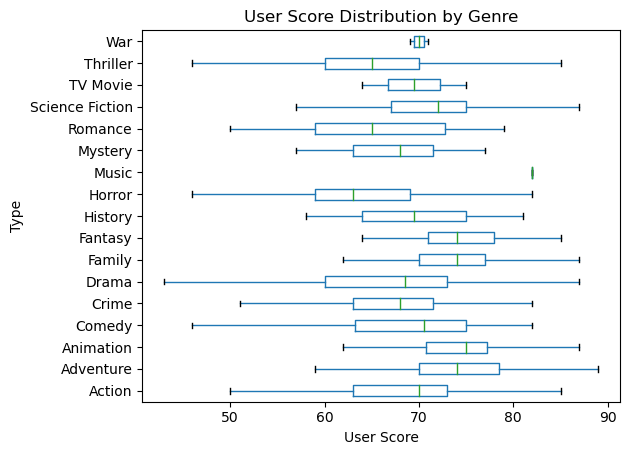

In [23]:
# Convert "User Score" to number
data['User Score'] = pd.to_numeric(data['User Score'], errors='coerce')

# Split the "Type" into different attributes
data['Type'] = data['Type'].str.split(',')
data_expanded = data.explode('Type').reset_index(drop=True)
data_expanded['Type'] = data_expanded['Type'].str.strip()

# 按Type分组并绘制箱形图
plt.figure(figsize=(12, 8))
data_expanded.boxplot(column='User Score', by='Type', grid=False, vert=False, showfliers=False)
plt.title('User Score Distribution by Genre')
plt.suptitle('')  # 移除默认的子标题
plt.xlabel('User Score')
plt.ylabel('Type')
plt.tight_layout()
plt.show()


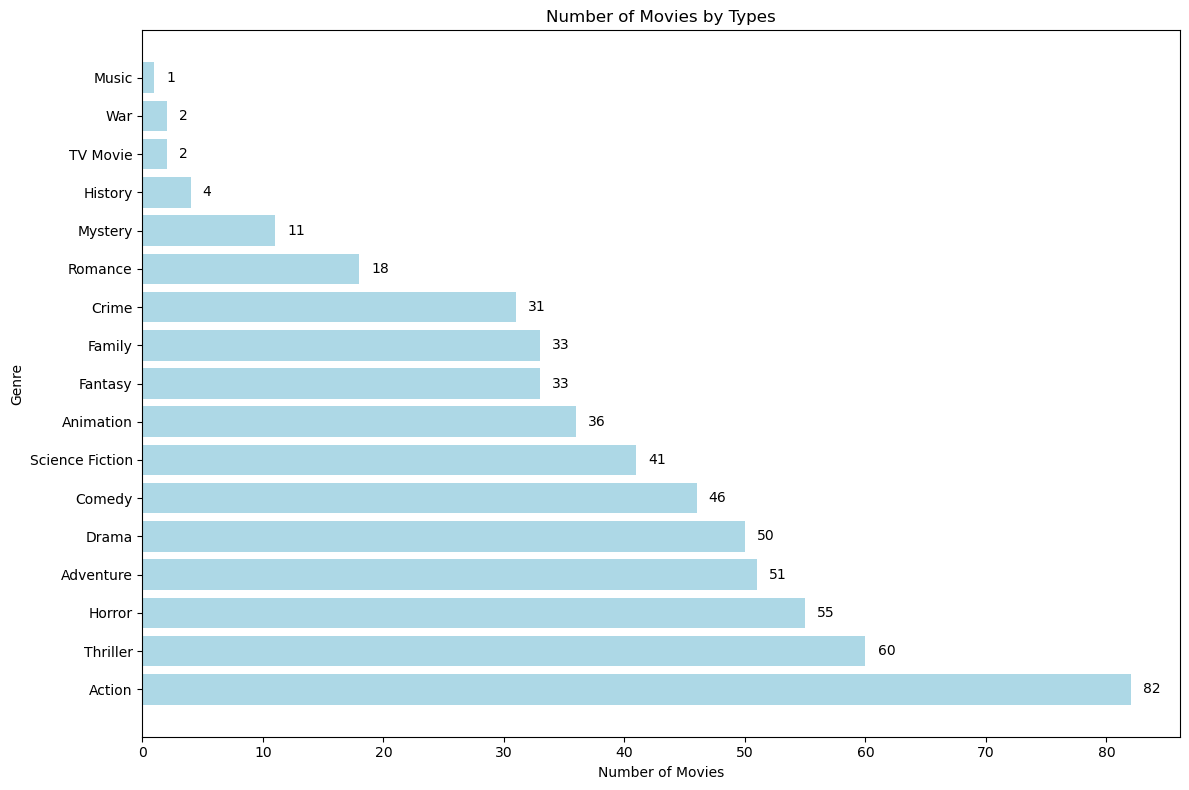

In [24]:
# Count the number of movies for each type
type_counts = data_expanded['Type'].value_counts()

# Plot a bar chart of the number of movies in each type
plt.figure(figsize=(12, 8))
bars = plt.barh(type_counts.index, type_counts.values, color='lightblue')
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', va='center')
plt.title('Number of Movies by Types')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


Overall: The movie ratings range is roughly the same across all genres, between 50 and 90 points.     
Outliers:At the same time, we found that there are two outliers: war movies and music movies. Combining the number of these two types of movies, we can find that these two movies do not have reference because of the small number of samples to be counted.

The genres ***"Fantasy," "Family," and "Animation"*** tend to have higher average user scores and shorter box plots, indicating more consistent and positive ratings. One possible reason for this is that these genres are often designed to appeal to a broad audience, including both children and adults. Movies in these categories typically emphasize storytelling, imaginative worlds, and emotional appeal, which resonate strongly with diverse viewers. Additionally, these genres often feature high-quality visual effects, engaging narratives, and heartwarming themes, which tend to evoke positive emotional responses. With over 30 films in each category, the consistent positive reception of these genres highlights their universal appeal and strong viewer satisfaction.

#### 2. Exploring the Relationship Between Movie Types and Return on Investment (RIO)

The second analysis focuses on examining the relationship between movie genres and their Return on Investment (RIO). Different movie genres come with varying production costs and box office potentials, which can significantly impact their financial success. By calculating the RIO for films across genres, we aim to uncover which genres tend to deliver higher or lower financial returns. Understanding the correlation between genres and RIO can provide valuable insights into the economic viability of different types of films, helping to identify which genres are most profitable and why.

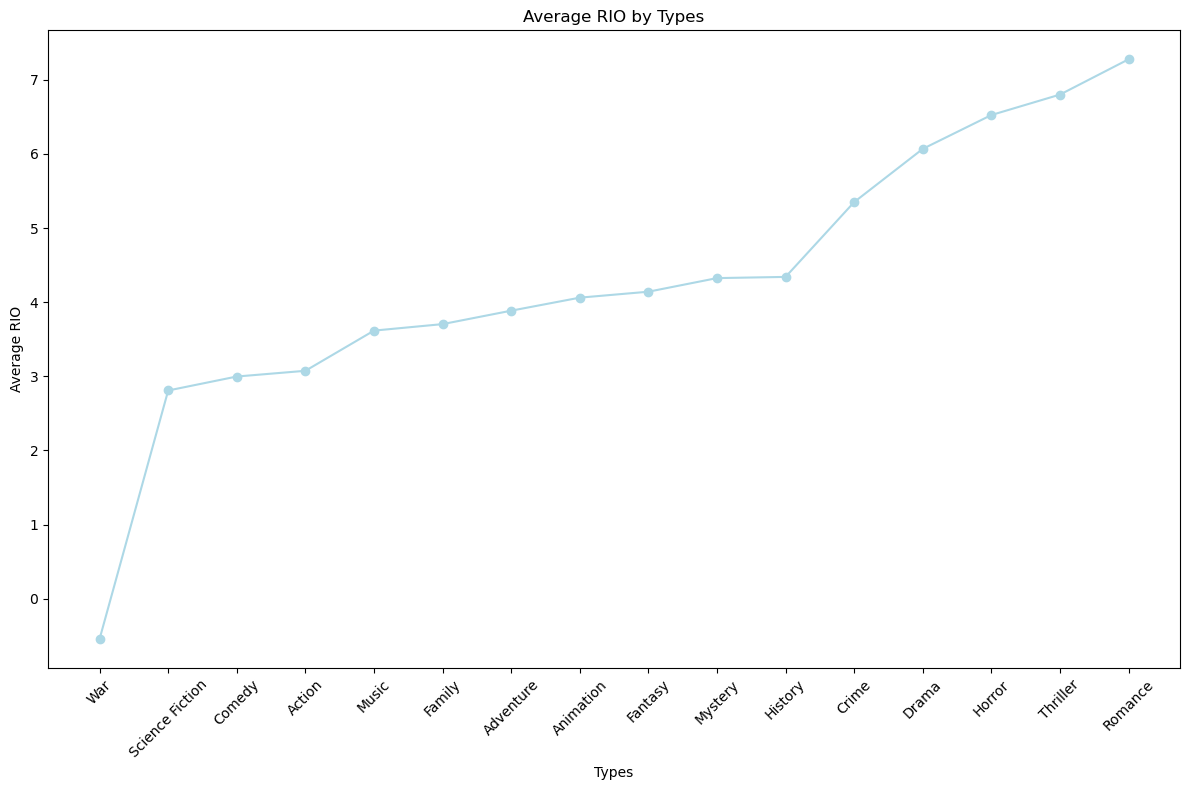

In [28]:
# First, calculate the RIO for each movie and then group the data by genre to analyze the relationship.

# Convert 'Budget' and 'Revenue' columns to numeric, removing any non-numeric characters
data_expanded['Budget'] = pd.to_numeric(data_expanded['Budget'].replace('[\$,]', '', regex=True), errors='coerce')
data_expanded['Revenue'] = pd.to_numeric(data_expanded['Revenue'].replace('[\$,]', '', regex=True), errors='coerce')

# Calculate RIO for each movie
data_expanded['RIO'] = (data_expanded['Revenue'] - data_expanded['Budget']) / data_expanded['Budget']

# Group by genre and calculate the average RIO for each genre
rio_by_genre = data_expanded.groupby('Type')['RIO'].mean().sort_values(ascending=False)
avg_rio_by_genre = data_expanded.groupby('Type')['RIO'].mean().sort_values()


plt.figure(figsize=(12, 8))
plt.plot(avg_rio_by_genre.index, avg_rio_by_genre.values, marker='o', linestyle='-', color='lightblue')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.title('Average RIO by Types')
plt.xlabel('Types')
plt.ylabel('Average RIO')
plt.tight_layout()  # Ensure layout fits
plt.show()


#### 3. Exploring the Relationship Between Movie Duration and Genres
The third analysis will explore the relationship between movie duration and movie genres. Movie durations can vary significantly across different genres, which can influence viewer engagement and the overall movie experience. By examining the distribution of movie durations within each genre, we aim to identify any patterns or trends that may exist. Understanding the correlation between movie duration and genres can provide insights into the optimal length for different types of films, potentially affecting the viewer's perception of the film's pacing and storytelling effectiveness.


In [30]:
def runtime_to_minutes(runtime_str):
    if 'h' in runtime_str:
        hours = int(runtime_str.split('h')[0].strip())
        minutes = int(runtime_str.split('h')[1].replace('m', '').strip()) if 'm' in runtime_str else 0
        return hours * 60 + minutes
    elif 'm' in runtime_str:
        return int(runtime_str.replace('m', '').strip())
    else:
        return None

# Apply the conversion
data_expanded['Length'] = data_expanded['Length'].apply(runtime_to_minutes)

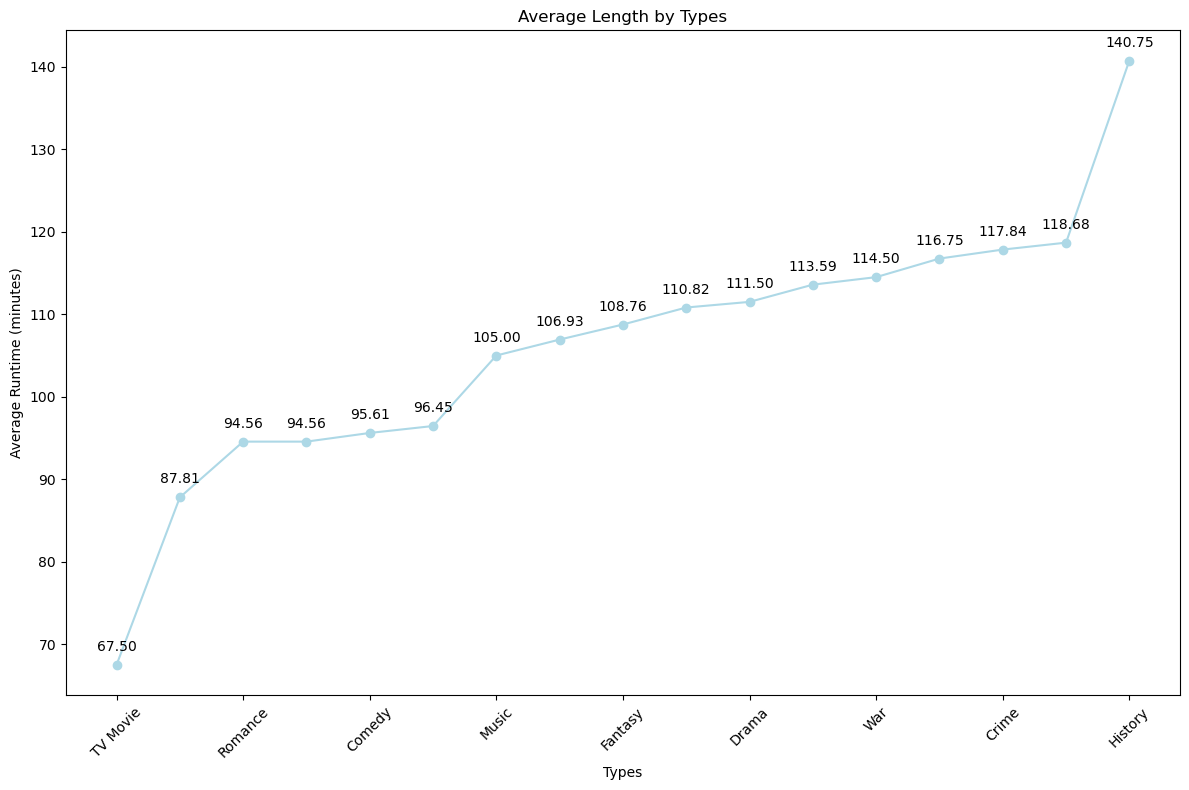

In [38]:
# Calculate the average runtime for each genre
avg_runtime_by_genre = data_expanded.groupby('Type')['Length'].mean().sort_values()

# Plot the average runtime by genre as a line chart with data labels
plt.figure(figsize=(12, 8))
avg_runtime_by_genre.plot(kind='line', marker='o', color='lightblue', label='Average Runtime')

# Add data labels to each point
for i, label in enumerate(avg_runtime_by_genre.index):
    plt.annotate(f'{avg_runtime_by_genre[i]:.2f}', (i, avg_runtime_by_genre[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Average Length by Types')
plt.xlabel('Types')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1400x1000 with 0 Axes>

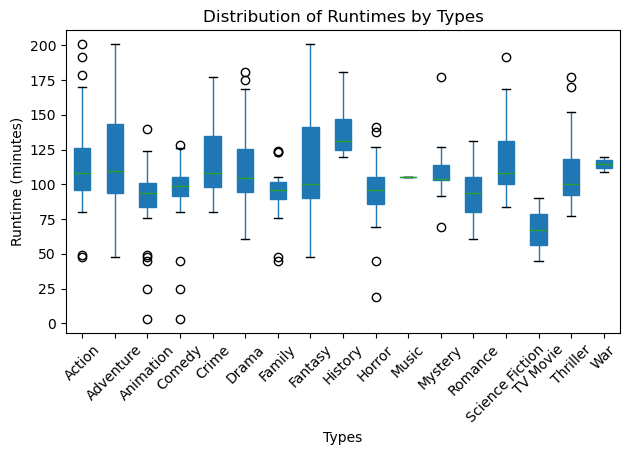

In [34]:
# Plot the distribution of runtimes by genre using a boxplot
plt.figure(figsize=(14, 10))
data_expanded.boxplot(column='Length', by='Type', grid=False, patch_artist=True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.title('Distribution of Runtimes by Types')
plt.suptitle('')  # Suppress default title to make it cleaner
plt.xlabel('Types')
plt.ylabel('Runtime (minutes)')
plt.tight_layout()
plt.show()


The analysis of the provided charts reveals that historical movies tend to have the longest average runtime, reaching up to 140.75 minutes, while TV movies are the shortest, with an average of just 67.50 minutes. Most other genres fall within the range of 90 to 120 minutes. Conversely, the Documentary genre shows a more concentrated runtime distribution with less variability, implying a more consistency in the length of documentaries produced. These insights could be valuable for film producers and distributors to understand the typical duration characteristics of different genres and the potential viewer expectations associated with each genre.